In [1]:
### packages ###
import random
import pandas as pd
import numpy as np
import json
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from matplotlib import ticker
import modelbase
from tqdm.notebook import tqdm

from modelbase.ode import Simulator
from scipy.integrate import trapezoid
from typing import Iterable, Dict, Tuple, Optional, Any, List, Union
import itertools as it
from matplotlib import cm
from modelbase.ode import mca

In [2]:
%%capture
cd ../..

In [3]:
from models import get_model

In [4]:
%%capture
cd model_changes_josha/

In [5]:
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

In [6]:
def plot_ppfd_petc_steady_state1(
    v: pd.DataFrame, c:pd.DataFrame, ax1: Optional[plt.Axes] = None
) -> Tuple[plt.Axes, plt.Axes]:
    if ax1 is None:
        _, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    v["vPS1"].plot(ax=ax1, label="rate through PS1")
    (v["vPS2"] * 2).plot(ax=ax1, label="LEF")
    (v["vCyc"] * 2).plot(ax=ax1, label="CEF")
    ax1.set(
        xlabel="PPFD/($\mu$mol m$^{-2}$s$^{-1}$)",
        ylabel="mmol e$^-$/mol Chl/s",
    )
    ax2.plot(c["pH"], "r--", label="pH")
    ax2.set(xlabel="PPFD")
    ax2.set_ylabel("pH", color="red"),
    ax2.tick_params(axis="y", labelcolor="red")
    return ax1, ax2


def plot_ppfd_redox_steady_state1(
    c: pd.DataFrame, ax1: Optional[plt.Axes] = None
) -> Tuple[plt.Axes, plt.Axes]:
    if ax1 is None:
        _, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    c["ATP_norm"].plot(ax=ax1, label="ATP", color="C0")
    c["NADP_redoxstate"].plot(ax=ax1, label="NADPH", color="C1")
    c["Fd_redoxstate"].plot(ax=ax1, label="reduced Fd", color="C2")
    c["PQ_redoxstate"].plot(ax=ax1, label="reduced PQ", color="C4")
    c["PC_redoxstate"].plot(ax=ax1, label="reduced PC", color="C5")
    ax1.set(xlabel="PPFD/($\mu$mol m$^{-2}$s$^{-1}$)", ylabel="Fraction of the pool")
    ax2.plot(c["H2O2"], "r--", label="H$_2$O$_2$")
    ax2.set_xlabel("PPFD/($\mu$mol\,m$^{-2}$s$^{-1}$)")
    ax2.set_ylabel("Concentration/mM", color="red")
    ax2.tick_params(axis="y", labelcolor="red")
    return ax1, ax2

In [7]:
#### no changes #####

In [8]:
s = Simulator(get_model())
s.initialise(y0)
c, v = s.parameter_scan_with_fluxes(
    "pfd",
    parameter_values=np.linspace(50, 1500, 50),
    multiprocessing=False,
)

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
oldpH=c["pH"]
oldQ=c["Q"]

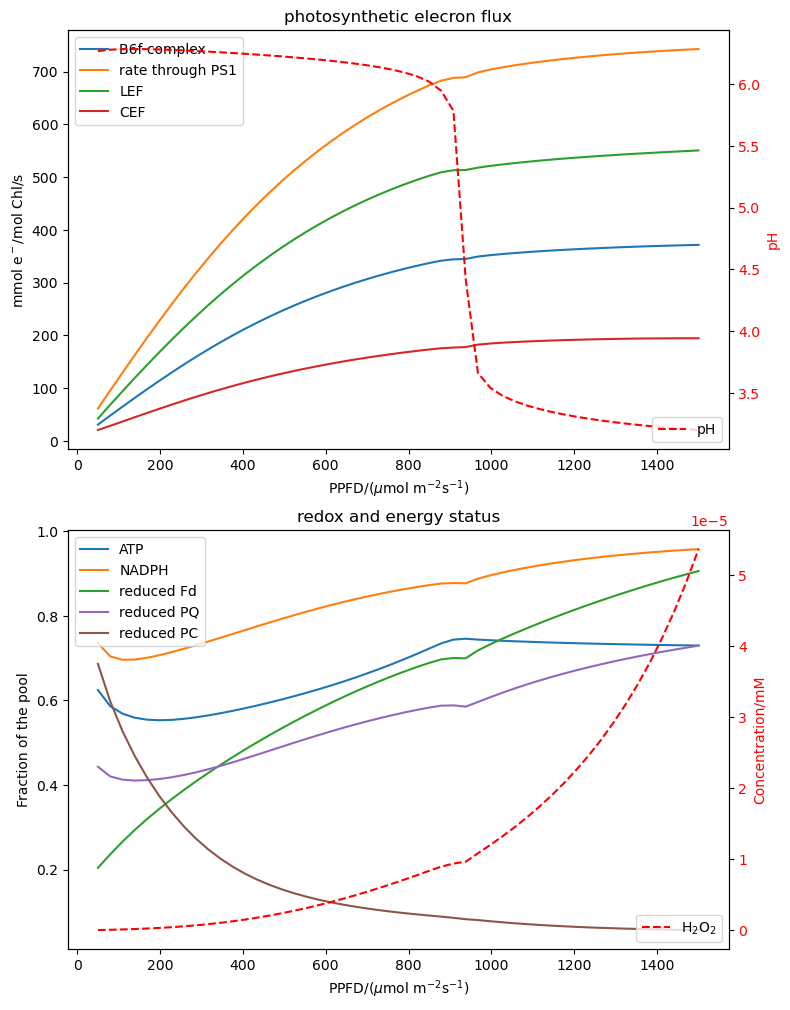

In [10]:
fig, (ax1, ax2) = plt.subplots(2,1 , figsize=(8,10))
ax1.plot(v["vB6f"], label="B6f complex")
(ax11, ax12)=plot_ppfd_petc_steady_state1(v,c, ax1)
ax12.legend(loc="lower right", borderaxespad=0.5)
(ax21, ax22) = plot_ppfd_redox_steady_state1(c, ax2)
ax22.legend(loc="lower right", borderaxespad=0.5)
fig.tight_layout(w_pad=5)
lines_labels = [ax.get_legend_handles_labels() for ax in [fig.axes[0]]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend()
ax2.legend(loc="upper left")
ax1.set_title("photosynthetic elecron flux")
ax2.set_title("redox and energy status")
plt.show()

In [11]:
def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])

In [12]:
mca_parameters = {
    "PSIItot": "PS2",
    "PSItot": "PS1",
    "kCytb6f": r"b$_6$f",
    "kcyc": "PGR5",
    "kMehler": "Mehler",
    "V1_base": "RuBisCO",
    "V6_base": "FBPase",
    "V9_base": "SBPase",
    "kcatMDAR": "MDAR",
    "kcat_DHAR": "DHAR",
}

mca_reactions = {
    "vPS2": "PS2",
    "vPS1": "PS1",
    "vB6f": r"b$_6$f",
    "vMehler": "Mehler",
    "vCyc": "CEF",
    "vRuBisCO": "RuBisCO",
    "vFBPase": "FBPase",
    "v9": "SBPase",
    "vMDAreduct": "MDAR",
    "vDHAR": "DHAR",
}

mca_compounds = {
    "PQ_redoxstate": "PQ$_\mathrm{red}$",
    "Fd_redoxstate": "Fd$_\mathrm{red}$",
    "PC_redoxstate": "PC$_\mathrm{red}$",
    "NADP_redoxstate": "NADPH",
    "ATP_norm": "ATP",
    "RUBP": "RUBP",
    "PGA": "PGA",
    "FBP": "FBP",
    "SBP": "SBP",
}

In [ ]:
s = Simulator(get_model())
s.initialise(y0)
s.update_parameter("pfd", 1000)
s.simulate_to_steady_state()
y0_1000 = get_new_y0(s)


s.initialise(y0)
s.update_parameter("pfd", 100)
s.simulate_to_steady_state()
y0_100 = get_new_y0(s)

m = get_model()
m.update_parameter("pfd", 1000)
ccc_1000_0, fcc_1000_0 = mca.get_response_coefficients_df(
    m,
    mca_parameters,
    y=y0_1000,
    displacement=0.01,
    multiprocessing=False
)

m.update_parameter("pfd", 100)
ccc_100_0, fcc_100_0 = mca.get_response_coefficients_df(
    m,
    mca_parameters,
    y=y0_100,
    displacement=0.01,
    multiprocessing=False
)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
#### changes ####

In [ ]:
m = get_model() #get model

In [ ]:
#add new parameters with values from Cruz et al., 2001
m.add_parameter("b6f_content", 1) #Journal of Experimental Botany, Vol. 65, No. 8, pp. 1955–1972, 2014
m.add_parameter("max_b6f", 500)
m.add_parameter("pKreg", 6.5)


m.remove_algebraic_module("Keq_B6f")

#m.update_parameter("E0_PQ", 0.11)
#m.update_parameter("E0_PC", 0.37)
##forward rate constant, consisiting of pH depending component that pumps protons into lumen
##protonation rate, which depends on pH and multiplied with scaling parameter

def Keq_cytb6f(pH,F, E0_PQ, E0_PC,dG_pH, pHstroma, RT):
    DG1 = -2 * F * E0_PQ #- 0.06*(pH-7.0)
    DG2 = -F * E0_PC
    DG = -(DG1 + 2 * dG_pH * pH) + 2 * DG2 + 2 * dG_pH * (pHstroma - pH)
    return np.exp(-DG / RT)


m.add_algebraic_module(
        module_name="Keq_B6f",
        function=Keq_cytb6f,
        compounds=["pH"],
        derived_compounds=["Keq_B6f"],
        parameters=["F","E0_PQ", "E0_PC","dG_pH", "pHstroma", "RT"],
    )

"""
def Keq_cytb6f(pH,F, E0_PQ, E0_PC, pHstroma, RT, dG_pH):
    DG1 = -2 * F * E0_PQ
    DG2 = -F * E0_PC
    #E02_PQ= E0_PQ - 0.06*(pH-7.0)
    return 10**((DG1 - DG2 - (dG_pH*(pH - pHstroma)))/RT)

m.add_algebraic_module(
        module_name="Keq_B6f",
        function=Keq_cytb6f,
        compounds=["pH"],
        derived_compounds=["Keq_B6f"],
        parameters=["F","E0_PQ", "E0_PC", "pHstroma","RT", "dG_pH"],
    )
"""



def k_b6f(pH , pKreg, b6f_content, max_b6f):
    pHmod=(1 - (1 / (10 ** (pH - pKreg) + 1)))
    b6f_deprot=pHmod*b6f_content
    return b6f_deprot * max_b6f

m.add_algebraic_module(module_name="k_b6f",
        function=k_b6f,
        compounds=["pH"],
        derived_compounds=["k_b6f"],
        parameters=["pKreg", "b6f_content", "max_b6f"],)

##because reaction is reversible forward rate constant/eq constant = reverse rate constant
#simple reaction rate, concentration substrates * forwards - concentration products - backwards
##!!!!!!!check whether it is necessary to keep PQ in fraction and not total number!!!!!!!
def vB6f(PC, PCred, PQ, PQred, k_b6f, Keq_B6f):    
    f_PQH2=PQred/(PQred+PQ) #want to keep the rates in terms of fraction of PQHs, not total number
    f_PQ=1-f_PQH2
    k_b6f_reverse = k_b6f / Keq_B6f
    
    return f_PQH2*PC*k_b6f - f_PQ*PCred*k_b6f_reverse 


m.add_reaction(
        rate_name="vB6f",
        function=vB6f,
        stoichiometry={"PC": -2, "PQ": 1, "H": 4 / m.get_parameter("bH")},
        modifiers=["PQred", "PCred", "k_b6f", "Keq_B6f"],
        dynamic_variables=["PC","PCred", "PQ", "PQred", "k_b6f","Keq_B6f"],
        reversible=True,
    )

In [21]:
s = Simulator(m)
s.initialise(y0)
s.update_parameter("pKreg",6.5)
s.update_parameter("max_b6f",500.0)
s.update_parameter("b6f_content", 1)
c1, v1 = s.parameter_scan_with_fluxes(
    "pfd",
    parameter_values=np.linspace(50, 1500, 50),
    multiprocessing=False,
)

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

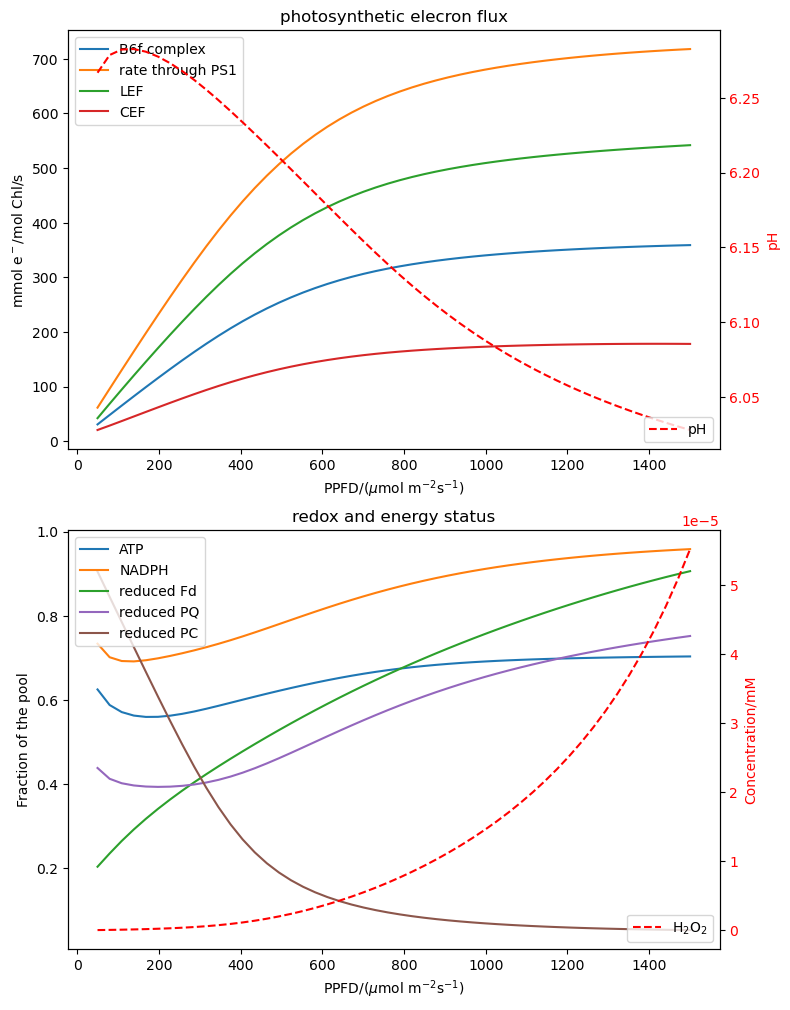

In [22]:
fig, (ax1, ax2) = plt.subplots(2,1 , figsize=(8,10))
ax1.plot(v1["vB6f"], label="B6f complex")
(ax11, ax12)=plot_ppfd_petc_steady_state1(v1,c1, ax1)
ax12.legend(loc="lower right", borderaxespad=0.5)
(ax21, ax22) = plot_ppfd_redox_steady_state1(c1, ax2)
ax22.legend(loc="lower right", borderaxespad=0.5)
fig.tight_layout(w_pad=5)
lines_labels = [ax.get_legend_handles_labels() for ax in [fig.axes[0]]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend()
ax2.legend(loc="upper left")
ax1.set_title("photosynthetic elecron flux")
ax2.set_title("redox and energy status")
plt.show()

In [ ]:
"""
s.update_parameter("pKreg",5.25)
s.update_parameter("max_b6f",500.0)
s.update_parameter("b6f_content", 0.433)
"""

In [23]:
s = Simulator(m)
s.initialise(y0)
s.update_parameter("pfd", 1000)
s.simulate_to_steady_state()
y0_1000 = get_new_y0(s)


s.initialise(y0)
s.update_parameter("pfd", 100)
s.simulate_to_steady_state()
y0_100 = get_new_y0(s)


m.update_parameter("pfd", 1000)
ccc_1000_1, fcc_1000_1 = mca.get_response_coefficients_df(
    m,
    mca_parameters,
    y=y0_1000,
    displacement=0.01,
    multiprocessing=False
)

m.update_parameter("pfd", 100)
ccc_100_1, fcc_100_1 = mca.get_response_coefficients_df(
    m,
    mca_parameters,
    y=y0_100,
    displacement=0.01,
    multiprocessing=False
)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [10]:
m.add_parameter("ATPturnover",80)
m.add_parameter("Ratecontrol_ATP", 0.45)
##mass kinetic quotient of ATP conversion
def ATP_gamma(Ratecontrol_ATP, Pi, ATP, ADP ,convf):
    return (ATP/convf)/((ADP/convf)*(Pi/1000)* Ratecontrol_ATP)

m.add_algebraic_module_from_args(
        module_name="ATP_gamma",
        function=ATP_gamma,
        args=["Ratecontrol_ATP","Pi", "ATP", "ADP", "convf"],
        derived_compounds=["ATP_gamma"])
###new Delta G with ATP gamma, could pack first term in algebraic module aswell
def deltagATPsyn(pH,gammaATP,DeltaG0_ATP,dG_pH, HPR, pHstroma, RT):
    DG = DeltaG0_ATP - dG_pH * HPR * (pHstroma - pH)+ RT* np.log(gammaATP)
    return DG

m.add_algebraic_module_from_args(
    module_name="DeltaGATPsyn",
    function=deltagATPsyn,
    args=["pH","ATP_gamma","DeltaG0_ATP","dG_pH", "HPR", "pHstroma", "RT"],
    derived_compounds=["DeltaGATPsyn"])


m.remove_reaction("vATPsynthase")

def vATPsynthase2(DeltaGATPsyn, ATPturnover):
    return -DeltaGATPsyn*ATPturnover

m.add_reaction(
        rate_name="vATPsynthase",
        function=vATPsynthase2,
        stoichiometry={
            "H": -m.get_parameter("HPR") / m.get_parameter("bH"),
            "ATP": 1 * m.get_parameter("convf"),
        },
        modifiers=["DeltaGATPsyn"],
        dynamic_variables=["DeltaGATPsyn"],
        parameters=["ATPturnover"],
        reversible=True)

In [15]:
"""
def Keq_ATP(pH, DeltaG0_ATP, dG_pH, HPR, pHstroma, Pi_mol, RT):
    DG = DeltaG0_ATP - dG_pH * HPR * (pHstroma - pH)
    Keq = Pi_mol * np.exp(-DG / RT)
    return Keq
def vATPsynthase(ATP, ADP, Keq_ATPsynthase, kATPsynth, convf):

    Reaction rate of ATP production
    Kinetic: simple mass action with PH dependant equilibrium
    Compartment: lumenal side of the thylakoid membrane
    Units:
    Reaction rate: mmol/mol Chl/s
    [ATP], [ADP] in mM
    
    return kATPsynth * (ADP / convf - ATP / convf / Keq_ATPsynthase)
"""

'\ndef Keq_ATP(pH, DeltaG0_ATP, dG_pH, HPR, pHstroma, Pi_mol, RT):\n    DG = DeltaG0_ATP - dG_pH * HPR * (pHstroma - pH)\n    Keq = Pi_mol * np.exp(-DG / RT)\n    return Keq\ndef vATPsynthase(ATP, ADP, Keq_ATPsynthase, kATPsynth, convf):\n\n    Reaction rate of ATP production\n    Kinetic: simple mass action with PH dependant equilibrium\n    Compartment: lumenal side of the thylakoid membrane\n    Units:\n    Reaction rate: mmol/mol Chl/s\n    [ATP], [ADP] in mM\n    \n    return kATPsynth * (ADP / convf - ATP / convf / Keq_ATPsynthase)\n'

In [25]:
s = Simulator(m)
s.initialise(y0)
c2, v2 = s.parameter_scan_with_fluxes(
    "pfd",
    parameter_values=np.linspace(50, 1500, 50),
    multiprocessing=False,
    **{'atol': 1.e-20}
    
)

pfd:   0%|          | 0/50 [00:00<?, ?it/s]

In [26]:
newpH=c2["pH"]
newQ=c2["Q"]

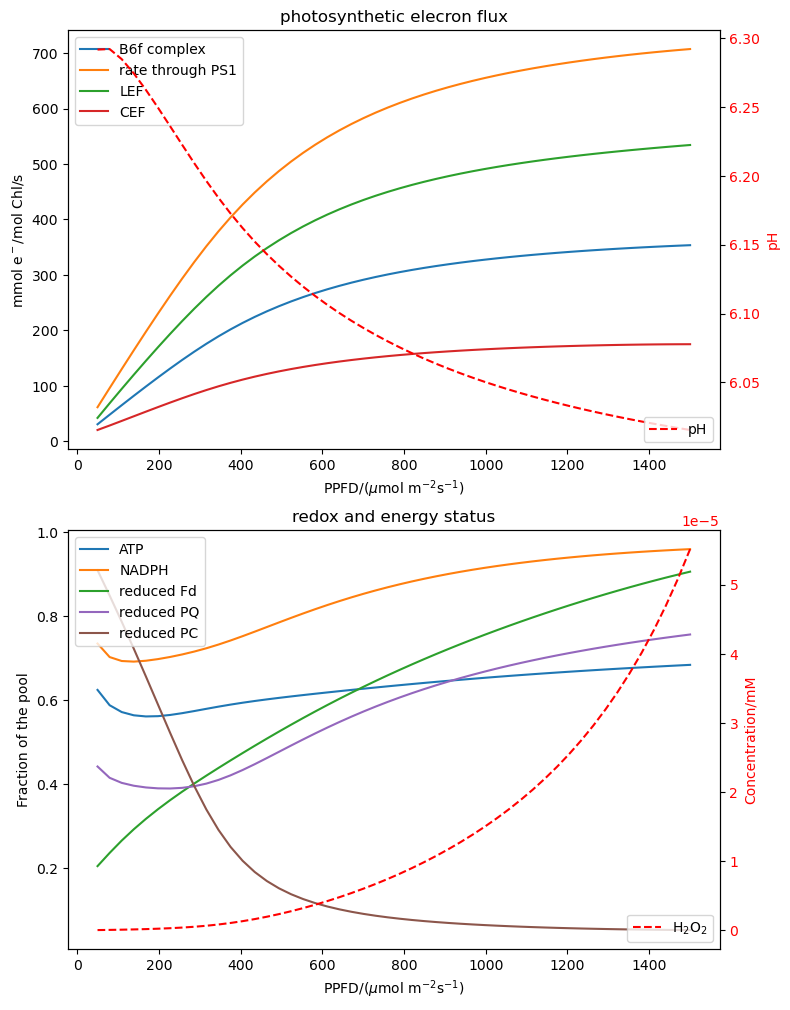

In [27]:
fig, (ax1, ax2) = plt.subplots(2,1 , figsize=(8,10))
ax1.plot(v2["vB6f"], label="B6f complex")
(ax11, ax12)=plot_ppfd_petc_steady_state1(v2,c2, ax1)
ax12.legend(loc="lower right", borderaxespad=0.5)
(ax21, ax22) = plot_ppfd_redox_steady_state1(c2, ax2)
ax22.legend(loc="lower right", borderaxespad=0.5)
fig.tight_layout(w_pad=5)
lines_labels = [ax.get_legend_handles_labels() for ax in [fig.axes[0]]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
ax1.legend()
ax2.legend(loc="upper left")
ax1.set_title("photosynthetic elecron flux")
ax2.set_title("redox and energy status")
plt.show()

In [14]:
s = Simulator(m)
s.initialise(y0)
s.update_parameter("pfd", 1000)
s.simulate_to_steady_state()
y0_1000 = get_new_y0(s)


s.initialise(y0)
s.update_parameter("pfd", 100)
s.simulate_to_steady_state()
y0_100 = get_new_y0(s)


m.update_parameter("pfd", 1000)
ccc_1000_2, fcc_1000_2 = mca.get_response_coefficients_df(
    m,
    mca_parameters,
    y=y0_1000,
    displacement=0.01,
    multiprocessing=False
)

m.update_parameter("pfd", 100)
ccc_100_2, fcc_100_2 = mca.get_response_coefficients_df(
    m,
    mca_parameters,
    y=y0_100,
    displacement=0.01,
    multiprocessing=False
)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

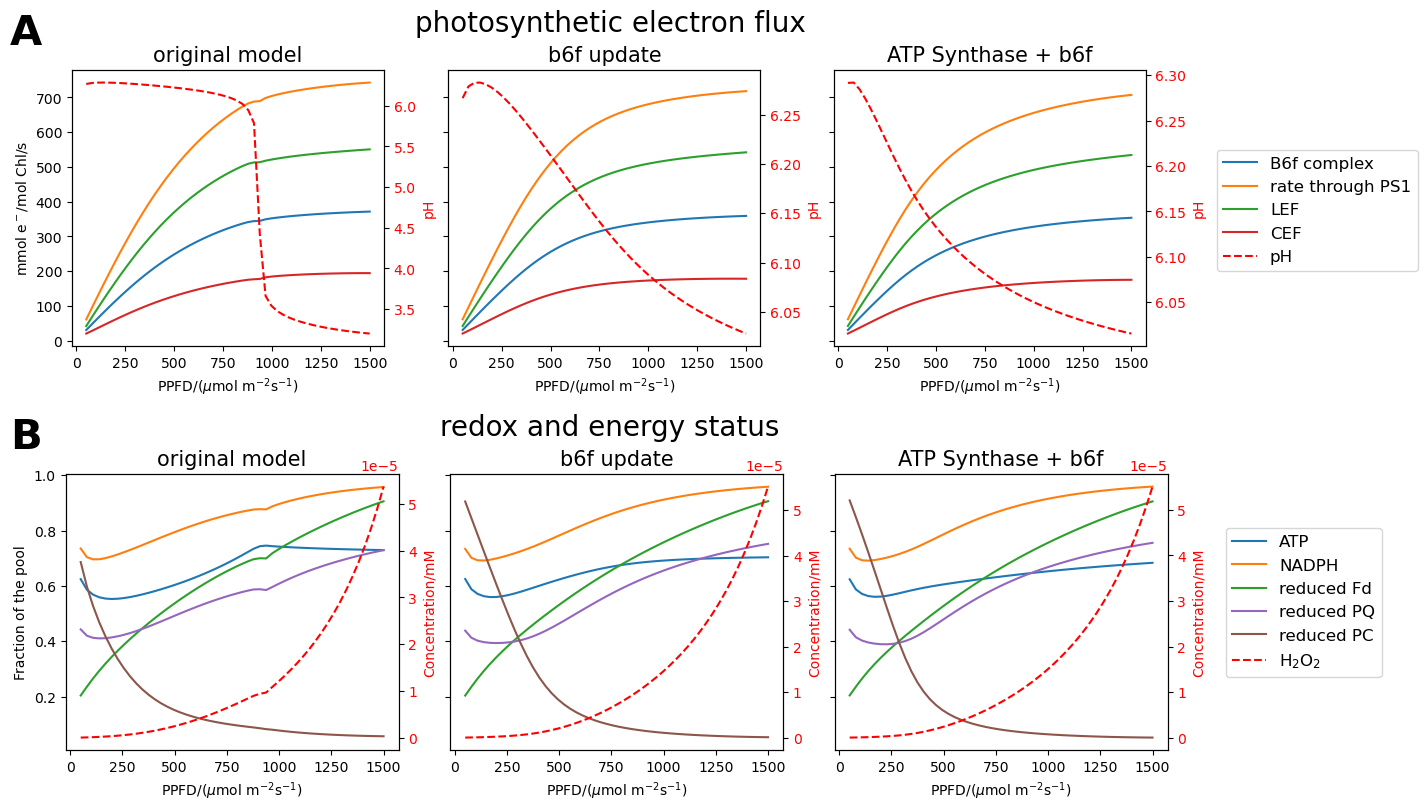

In [29]:
fig, axs = plt.subplots(2,3, layout='constrained',figsize=(12,8))
gridspec = axs[0, 0].get_subplotspec().get_gridspec()
gridspec2 = axs[1, 0].get_subplotspec().get_gridspec()
for a in axs[0,:]:
    a.remove()
for a in axs[1,:]:
    a.remove()

subfig = fig.add_subfigure(gridspec[0, :] )
subfig2 = fig.add_subfigure(gridspec2[1, :])
subfig.suptitle('photosynthetic electron flux', fontsize=20)
subfig2.suptitle('redox and energy status', fontsize=20)
axsup = subfig.subplots(1, 3,sharey=True)
axdown= subfig2.subplots(1, 3, sharey=True)
axsup[0].plot(v["vB6f"], label="B6f complex")
plot_ppfd_petc_steady_state1(v,c, axsup[0])

axsup[1].plot(v1["vB6f"], label="B6f complex")
plot_ppfd_petc_steady_state1(v1,c1, axsup[1])
axsup[2].plot(v2["vB6f"], label="B6f complex")
plot_ppfd_petc_steady_state1(v2,c2, axsup[2])

plot_ppfd_redox_steady_state1(c, axdown[0])
plot_ppfd_redox_steady_state1(c1, axdown[1])
plot_ppfd_redox_steady_state1(c2, axdown[2])
axsup[0].set_title("original model",fontsize=15)
axdown[0].set_title("original model",fontsize=15)
axsup[1].set_title("b6f update",fontsize=15)
axdown[1].set_title("b6f update",fontsize=15)
axsup[2].set_title("ATP Synthase + b6f",fontsize=15)
axdown[2].set_title("ATP Synthase + b6f",fontsize=15)
lines_labels = [ax.get_legend_handles_labels() for ax in [fig.axes[0], fig.axes[8]]]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines, labels,bbox_to_anchor=[1.18, 0.83], loc="upper right", fontsize=12)

lines_labels = [ax.get_legend_handles_labels() for ax in [fig.axes[4], fig.axes[11]]]
lines2, labels2 = [sum(lol, []) for lol in zip(*lines_labels)]
fig.legend(lines2, labels2, bbox_to_anchor=[1.15, 0.15],loc="lower right",fontsize=12)
subfig.text(0, 0.9, "A", fontdict={'fontsize': 30, 'fontweight': 'heavy'})
subfig2.text(0, 0.9, "B", fontdict={'fontsize': 30, 'fontweight': 'heavy'})
#plt.subplots_adjust(wspace=0.35)
plt.show()

In [30]:
first_max_f=max(fcc_1000_0[["vPS2",
    "vPS1",
    "vB6f",
    "vMehler",
    "vCyc",
    "vRuBisCO",
    "vFBPase",
    "v9",
    "vMDAreduct",
    "vDHAR"]].max())

first_min_f = min(fcc_1000_0[["vPS2",
    "vPS1",
    "vB6f",
    "vMehler",
    "vCyc",
    "vRuBisCO",
    "vFBPase",
    "v9",
    "vMDAreduct",
    "vDHAR"]].min())

first_max_c=max(ccc_1000_0[["PQ_redoxstate",
    "Fd_redoxstate",
    "PC_redoxstate",
    "NADP_redoxstate",
    "ATP_norm",
    "RUBP",
    "PGA",
    "FBP",
    "SBP"]].max())

first_min_c=min(ccc_1000_0[["PQ_redoxstate",
    "Fd_redoxstate",
    "PC_redoxstate",
    "NADP_redoxstate",
    "ATP_norm",
    "RUBP",
    "PGA",
    "FBP",
    "SBP"]].min())

In [31]:
sec_max_f=max(fcc_1000_1[["vPS2",
    "vPS1",
    "vB6f",
    "vMehler",
    "vCyc",
    "vRuBisCO",
    "vFBPase",
    "v9",
    "vMDAreduct",
    "vDHAR"]].max())

sec_min_f = min(fcc_1000_1[["vPS2",
    "vPS1",
    "vB6f",
    "vMehler",
    "vCyc",
    "vRuBisCO",
    "vFBPase",
    "v9",
    "vMDAreduct",
    "vDHAR"]].min())

sec_max_c=max(ccc_1000_1[["PQ_redoxstate",
    "Fd_redoxstate",
    "PC_redoxstate",
    "NADP_redoxstate",
    "ATP_norm",
    "RUBP",
    "PGA",
    "FBP",
    "SBP"]].max())

sec_min_c=min(ccc_1000_1[["PQ_redoxstate",
    "Fd_redoxstate",
    "PC_redoxstate",
    "NADP_redoxstate",
    "ATP_norm",
    "RUBP",
    "PGA",
    "FBP",
    "SBP"]].min())

In [32]:
thi_max_f=max(fcc_1000_2[["vPS2",
    "vPS1",
    "vB6f",
    "vMehler",
    "vCyc",
    "vRuBisCO",
    "vFBPase",
    "v9",
    "vMDAreduct",
    "vDHAR"]].max())

thi_min_f = min(fcc_1000_2[["vPS2",
    "vPS1",
    "vB6f",
    "vMehler",
    "vCyc",
    "vRuBisCO",
    "vFBPase",
    "v9",
    "vMDAreduct",
    "vDHAR"]].min())

thi_max_c=max(ccc_1000_2[["PQ_redoxstate",
    "Fd_redoxstate",
    "PC_redoxstate",
    "NADP_redoxstate",
    "ATP_norm",
    "RUBP",
    "PGA",
    "FBP",
    "SBP"]].max())

thi_min_c=min(ccc_1000_2[["PQ_redoxstate",
    "Fd_redoxstate",
    "PC_redoxstate",
    "NADP_redoxstate",
    "ATP_norm",
    "RUBP",
    "PGA",
    "FBP",
    "SBP"]].min())

In [33]:
c_max_1000=max(first_max_c, sec_max_c, thi_max_c)
c_min_1000=min(first_min_c, sec_min_c, thi_min_c)
f_max_1000=max(first_max_c, sec_max_f, thi_max_f)
f_min_1000=min(first_min_f, sec_min_f, thi_min_f)

In [34]:
first_max_f=max(fcc_100_0[["vPS2",
    "vPS1",
    "vB6f",
    "vMehler",
    "vCyc",
    "vRuBisCO",
    "vFBPase",
    "v9",
    "vMDAreduct",
    "vDHAR"]].max())

first_min_f = min(fcc_100_0[["vPS2",
    "vPS1",
    "vB6f",
    "vMehler",
    "vCyc",
    "vRuBisCO",
    "vFBPase",
    "v9",
    "vMDAreduct",
    "vDHAR"]].min())

first_max_c=max(ccc_100_0[["PQ_redoxstate",
    "Fd_redoxstate",
    "PC_redoxstate",
    "NADP_redoxstate",
    "ATP_norm",
    "RUBP",
    "PGA",
    "FBP",
    "SBP"]].max())

first_min_c=min(ccc_100_0[["PQ_redoxstate",
    "Fd_redoxstate",
    "PC_redoxstate",
    "NADP_redoxstate",
    "ATP_norm",
    "RUBP",
    "PGA",
    "FBP",
    "SBP"]].min())

In [35]:
sec_max_f=max(fcc_100_1[["vPS2",
    "vPS1",
    "vB6f",
    "vMehler",
    "vCyc",
    "vRuBisCO",
    "vFBPase",
    "v9",
    "vMDAreduct",
    "vDHAR"]].max())

sec_min_f = min(fcc_100_1[["vPS2",
    "vPS1",
    "vB6f",
    "vMehler",
    "vCyc",
    "vRuBisCO",
    "vFBPase",
    "v9",
    "vMDAreduct",
    "vDHAR"]].min())

sec_max_c=max(ccc_100_1[["PQ_redoxstate",
    "Fd_redoxstate",
    "PC_redoxstate",
    "NADP_redoxstate",
    "ATP_norm",
    "RUBP",
    "PGA",
    "FBP",
    "SBP"]].max())

sec_min_c=min(ccc_100_1[["PQ_redoxstate",
    "Fd_redoxstate",
    "PC_redoxstate",
    "NADP_redoxstate",
    "ATP_norm",
    "RUBP",
    "PGA",
    "FBP",
    "SBP"]].min())

In [36]:
thi_max_f=max(fcc_100_2[["vPS2",
    "vPS1",
    "vB6f",
    "vMehler",
    "vCyc",
    "vRuBisCO",
    "vFBPase",
    "v9",
    "vMDAreduct",
    "vDHAR"]].max())

thi_min_f = min(fcc_100_2[["vPS2",
    "vPS1",
    "vB6f",
    "vMehler",
    "vCyc",
    "vRuBisCO",
    "vFBPase",
    "v9",
    "vMDAreduct",
    "vDHAR"]].min())

thi_max_c=max(ccc_100_2[["PQ_redoxstate",
    "Fd_redoxstate",
    "PC_redoxstate",
    "NADP_redoxstate",
    "ATP_norm",
    "RUBP",
    "PGA",
    "FBP",
    "SBP"]].max())

thi_min_c=min(ccc_100_2[["PQ_redoxstate",
    "Fd_redoxstate",
    "PC_redoxstate",
    "NADP_redoxstate",
    "ATP_norm",
    "RUBP",
    "PGA",
    "FBP",
    "SBP"]].min())

In [37]:
c_max_100=max(first_max_c, sec_max_c, thi_max_c)
c_min_100=min(first_min_c, sec_min_c, thi_min_c)
f_max_100=max(first_max_c, sec_max_f, thi_max_f)
f_min_100=min(first_min_f, sec_min_f, thi_min_f)

In [16]:
from matplotlib.colors import TwoSlopeNorm

NameError: name 'fcc_1000_0' is not defined

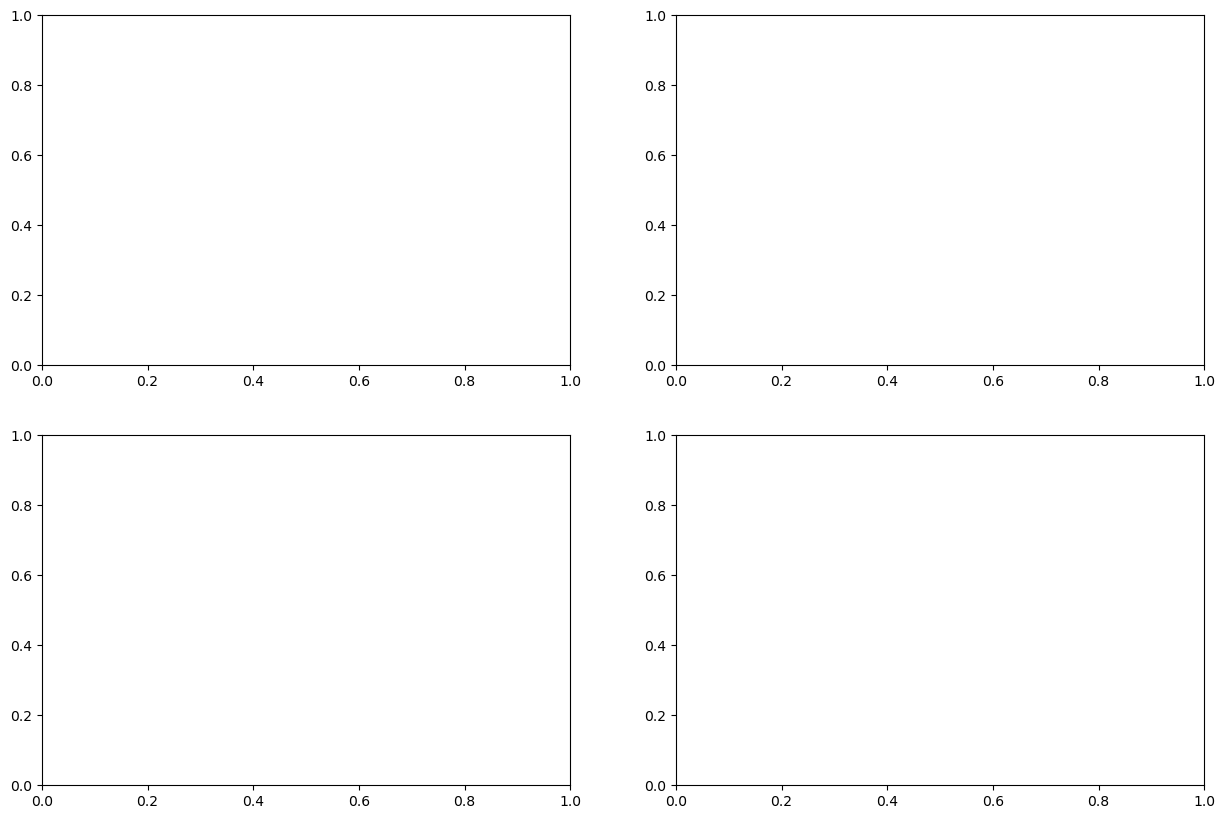

In [17]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
mca.plot_coefficient_heatmap(
    fcc_1000_0,
    title="Flux Control Coefficient",
    rows=mca_reactions,
    annotate=False,
    ax=ax1,
    norm=TwoSlopeNorm(vcenter=0),
)
mca.plot_coefficient_heatmap(
    ccc_1000_0,
    title="Concentration Control Coefficient",
    rows=mca_compounds,
    annotate=False,
    ax=ax2,
    norm=TwoSlopeNorm(vcenter=0),
)

ax1.set_xticklabels(mca_parameters.values(), rotation=90)
ax1.set_yticklabels(mca_reactions.values())
ax2.set_xticklabels(mca_parameters.values(), rotation=90)
ax2.set_yticklabels(mca_compounds.values())


mca.plot_coefficient_heatmap(
    fcc_100_0,
    title="",
    rows=mca_reactions,
    annotate=False,
    ax=ax3,
    norm=TwoSlopeNorm(vcenter=0),
)
mca.plot_coefficient_heatmap(
    ccc_100_0,
    title="",
    rows=mca_compounds,
    annotate=False,
    ax=ax4,
    norm=TwoSlopeNorm(vcenter=0),
)

ax3.set_xticklabels(mca_parameters.values(), rotation=90)
ax3.set_yticklabels(mca_reactions.values())
ax4.set_xticklabels(mca_parameters.values(), rotation=90)
ax4.set_yticklabels(mca_compounds.values())
fig.text(
    0.5, 1, "PPFD = 1000 $\mathrm{µmol\ m^{-2}\ s^{-1}}$", fontsize=16, ha="center"
)
fig.text(
    0.5, 0.5, "PPFD = 100 $\mathrm{µmol\ m^{-2}\ s^{-1}}$", fontsize=16, ha="center"
)

fig.tight_layout(h_pad=4)
plt.savefig("fig-6.png", bbox_inches="tight")
plt.show()

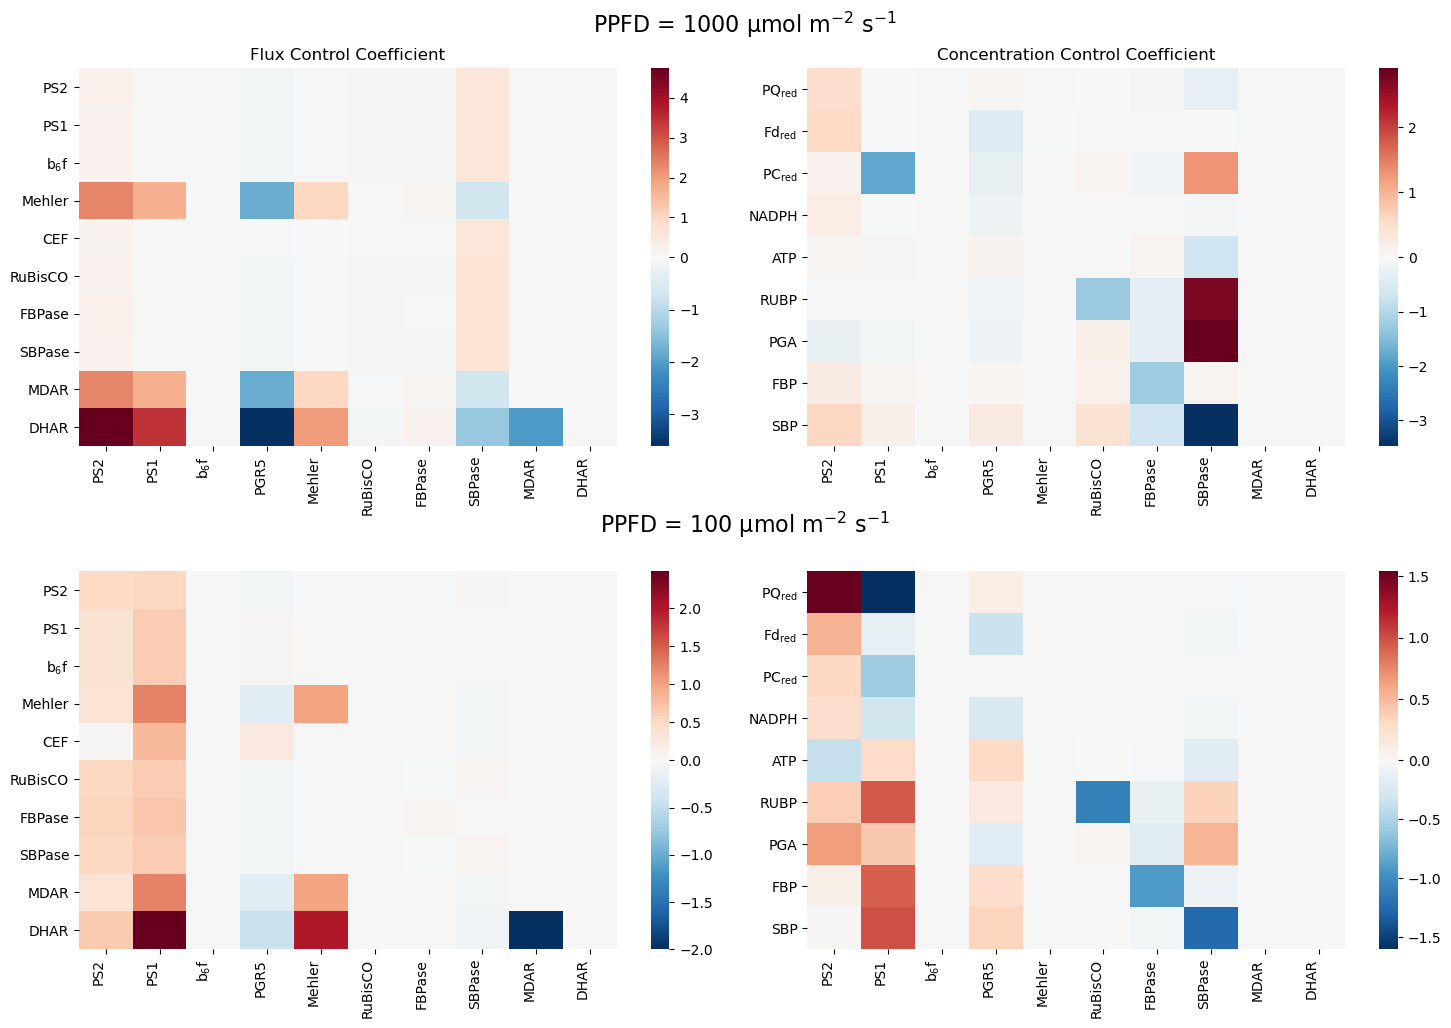

In [40]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
mca.plot_coefficient_heatmap(
    fcc_1000_1,
    title="Flux Control Coefficient",
    rows=mca_reactions,
    annotate=False,
    ax=ax1,
    norm=TwoSlopeNorm(vcenter=0),
)
mca.plot_coefficient_heatmap(
    ccc_1000_1,
    title="Concentration Control Coefficient",
    rows=mca_compounds,
    annotate=False,
    ax=ax2,
    norm=TwoSlopeNorm(vcenter=0),
)

ax1.set_xticklabels(mca_parameters.values(), rotation=90)
ax1.set_yticklabels(mca_reactions.values())
ax2.set_xticklabels(mca_parameters.values(), rotation=90)
ax2.set_yticklabels(mca_compounds.values())


mca.plot_coefficient_heatmap(
    fcc_100_1,
    title="",
    rows=mca_reactions,
    annotate=False,
    ax=ax3,
    norm=TwoSlopeNorm(vcenter=0),
)
mca.plot_coefficient_heatmap(
    ccc_100_1,
    title="",
    rows=mca_compounds,
    annotate=False,
    ax=ax4,
    norm=TwoSlopeNorm(vcenter=0),
)

ax3.set_xticklabels(mca_parameters.values(), rotation=90)
ax3.set_yticklabels(mca_reactions.values())
ax4.set_xticklabels(mca_parameters.values(), rotation=90)
ax4.set_yticklabels(mca_compounds.values())
fig.text(
    0.5, 1, "PPFD = 1000 $\mathrm{µmol\ m^{-2}\ s^{-1}}$", fontsize=16, ha="center"
)
fig.text(
    0.5, 0.5, "PPFD = 100 $\mathrm{µmol\ m^{-2}\ s^{-1}}$", fontsize=16, ha="center"
)

fig.tight_layout(h_pad=4)
plt.savefig("fig-6.png", bbox_inches="tight")
plt.show()

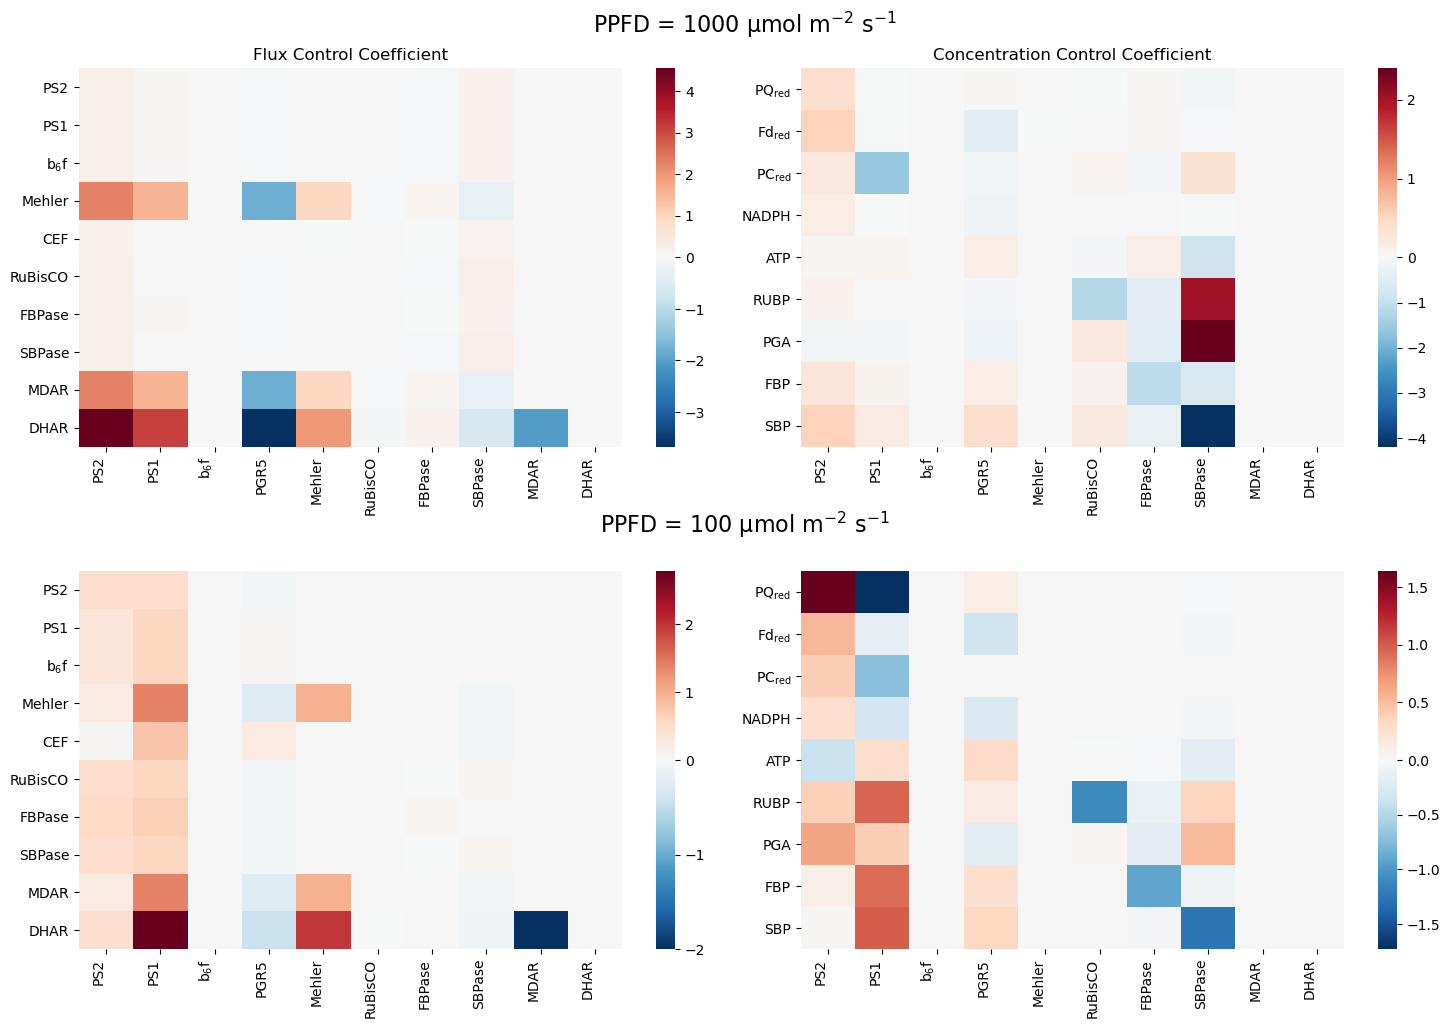

In [18]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
mca.plot_coefficient_heatmap(
    fcc_1000_2,
    title="Flux Control Coefficient",
    rows=mca_reactions,
    annotate=False,
    ax=ax1,
    norm=TwoSlopeNorm(vcenter=0),
)
mca.plot_coefficient_heatmap(
    ccc_1000_2,
    title="Concentration Control Coefficient",
    rows=mca_compounds,
    annotate=False,
    ax=ax2,
    norm=TwoSlopeNorm(vcenter=0),
)

ax1.set_xticklabels(mca_parameters.values(), rotation=90)
ax1.set_yticklabels(mca_reactions.values())
ax2.set_xticklabels(mca_parameters.values(), rotation=90)
ax2.set_yticklabels(mca_compounds.values())


mca.plot_coefficient_heatmap(
    fcc_100_2,
    title="",
    rows=mca_reactions,
    annotate=False,
    ax=ax3,
    norm=TwoSlopeNorm(vcenter=0),
)
mca.plot_coefficient_heatmap(
    ccc_100_2,
    title="",
    rows=mca_compounds,
    annotate=False,
    ax=ax4,
    norm=TwoSlopeNorm(vcenter=0),
)

ax3.set_xticklabels(mca_parameters.values(), rotation=90)
ax3.set_yticklabels(mca_reactions.values())
ax4.set_xticklabels(mca_parameters.values(), rotation=90)
ax4.set_yticklabels(mca_compounds.values())
fig.text(
    0.5, 1, "PPFD = 1000 $\mathrm{µmol\ m^{-2}\ s^{-1}}$", fontsize=16, ha="center"
)
fig.text(
    0.5, 0.5, "PPFD = 100 $\mathrm{µmol\ m^{-2}\ s^{-1}}$", fontsize=16, ha="center"
)

fig.tight_layout(h_pad=4)
plt.savefig("fig-6.png", bbox_inches="tight")
plt.show()